# Install libraries, packages and dataset

In [1]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052 (from 1)
Receiving objects: 100% (34052/34052), 52.31 MiB | 11.49 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pyf34vsp
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pyf34vsp
  Resolved https://github.com/albumentations-team/albumentations to commit 80c58e1ea08bebcd664e3537a66bbcaf0d3863b5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 35.7 MB/s eta 0:00:00
  Created wheel for albumentations: filename

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [3]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation'
LR = 0.001 #Learning Rate
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = 'cuda'
MODEL_NAME = 'efficient_b0'

# Load Dataset

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [5]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation( degrees = (-30, +30)),
    T.ToTensor()
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [6]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [7]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [8]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

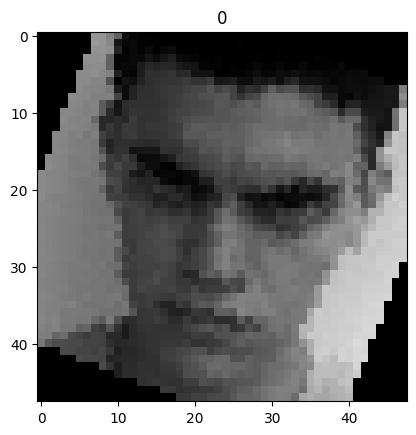

In [9]:
image, label = trainset[50]
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

# Load Dataset into Batches

In [10]:
from torch.utils.data import DataLoader

In [11]:
trainloader = DataLoader(trainset,  batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset,  batch_size = BATCH_SIZE)

In [12]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [13]:
for images, labels in trainloader:
    break
print(f"One image batch shape: {images.shape}")
print(f"One label batch shape: {labels.shape}")


One image batch shape: torch.Size([32, 3, 48, 48])
One label batch shape: torch.Size([32])


# Create Model

In [14]:
import timm
from torch import nn

In [15]:
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel, self).__init__()
        self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 7)

    def forward(self, images, labels=None):
        logits = self.eff_net(images)
        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss
        return logits

In [16]:
model = FaceModel()
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv

# Create Train and Eval Function

In [17]:
from tqdm import tqdm

In [18]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [19]:
def train_fn(model, dataloader, optimizer, current_epo):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t + 1)), 'acc' : '%6f' %float(total_acc / (t + 1)), })

  return total_loss / len(dataloader), total_acc / len(dataloader)


In [20]:
def eval_fn(model, dataloader, current_epo):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[VALID]" + str(current_epo + 1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t + 1)), 'acc' : '%6f' %float(total_acc / (t + 1)), })

  return total_loss / len(dataloader), total_acc / len(dataloader)


# Create Training Loop

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [22]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('Saved Best Weights')
    best_valid_loss = valid_loss

EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:07<00:00, 30.32it/s, loss=1.355986, acc=0.481890]


Saved Best Weights


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:06<00:00, 35.62it/s, loss=1.217475, acc=0.529336]


Saved Best Weights


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:06<00:00, 32.49it/s, loss=1.163297, acc=0.563718]


Saved Best Weights


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:06<00:00, 34.40it/s, loss=1.161173, acc=0.565165]


Saved Best Weights


EPOCH[VALID]5/15: 100%|██████████| 221/221 [00:06<00:00, 34.29it/s, loss=1.098152, acc=0.589062]


Saved Best Weights


EPOCH[VALID]6/15: 100%|██████████| 221/221 [00:10<00:00, 21.03it/s, loss=1.045078, acc=0.613285]


Saved Best Weights


EPOCH[VALID]7/15: 100%|██████████| 221/221 [00:06<00:00, 33.10it/s, loss=1.030418, acc=0.610251]


Saved Best Weights


EPOCH[VALID]9/15: 100%|██████████| 221/221 [00:06<00:00, 33.77it/s, loss=1.024671, acc=0.624141]


Saved Best Weights


EPOCH[VALID]12/15: 100%|██████████| 221/221 [00:06<00:00, 34.24it/s, loss=1.019594, acc=0.624500]


Saved Best Weights


EPOCH[VALID]13/15: 100%|██████████| 221/221 [00:06<00:00, 34.11it/s, loss=0.994008, acc=0.634996]


Saved Best Weights


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:06<00:00, 32.61it/s, loss=1.008910, acc=0.624935]


# Inference

In [23]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

<ipython-input-24-58f5808a4f8a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-weights.pt'))


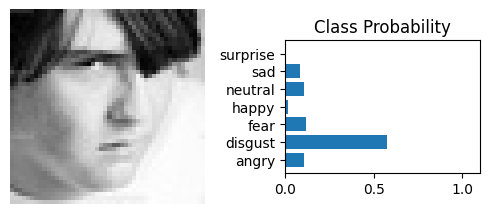

In [24]:
model.load_state_dict(torch.load('best-weights.pt'))
model.eval()

image, label = validset[40]
image = image.unsqueeze(0)

image = image.to(DEVICE)

with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits, dim=1)

view_classify(image.cpu().squeeze(), probs.cpu())

##Validation Accuracy

In [26]:
model.load_state_dict(torch.load('best-weights.pt'))
model.eval()

valid_loss, valid_acc = eval_fn(model, validloader, current_epo=0)  # current_epo is a placeholder
print(f"Validation Accuracy: {valid_acc * 100:.2f}%")

<ipython-input-26-46e6e1191760>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-weights.pt'))
EPOCH[VALID]1/15: 100%|██████████| 221/

Validation Accuracy: 63.50%
